In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from itertools import combinations

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
FID_label = ['AR','FT','MCS','LPS','AF','AM','AL','FM','FL','ML','AFM','AFL','AML','FML','All','UE','DC','CG']

In [4]:
def process_data_fid_update(data_fid_mask, front_replace=False):
    
    """ updating the origional FID data by adding DC and CG
        set front_replace = True to replace FT and FT-associated labels over the tropics
        input: data_fid_mask (time, lat, lon), feat_comb_label
    """

    data_fid_label = data_fid_mask.feat_comb_label
    data_dc_mask = data_fid_mask.deep_conv_mask # (0,1)
    data_cg_mask = data_fid_mask.nondeep_conv_mask + 1 # now is (1,2) instead for later screening processes 
    
    if front_replace == False:
    
        data_dc_label = data_dc_mask.where((data_dc_mask == 1) & (data_fid_label == 16), 0)
        data_cg_label = data_cg_mask.where((data_cg_mask == 2) & (data_fid_label == 16), 0)

        data_fid_final = data_fid_label + data_dc_label + data_cg_label # now ranges from 1 to 18    
    
    if front_replace == True:
        
        ### ad-hoc approach to mask out "FT" and the associated over the tropics
        FID_label = ['AR','FT','MCS','LPS','AF','AM','AL','FM','FL','ML','AFM'
                     ,'AFL','AML','FML','All','UE','DC','CG']
        idx_F = []
        for n,fid in enumerate(FID_label):
            for char in fid:
                if (char == 'F') or (char == 'l'): # label with front and All
                    idx_F.append(n+1)
                    break
        idx_F_replace = [16, 1, 3, 4, 6, 7, 10, 13] # convert to: UE, AR, MCS, LPS, AM, AL, ML, AML
    
        # keep mid-high latitudes
        dum1 = data_fid_label.where((data_fid_label.latitude >= 20), 0)
        dum2 = data_fid_label.where((data_fid_label.latitude <= -20), 0)
        data_fid_extra = dum1 + dum2
        
        # keep tropics for unaffected labels
        cond_tropics = (data_fid_label.latitude < 20) & (data_fid_label.latitude > -20)
        data_fid_tropics = data_fid_label.where(cond_tropics, 0)

        data_fid_list = []
        for label_F, label_replace in zip(idx_F, idx_F_replace):

            data_fid_unique = data_fid_label.copy()
            data_fid_unique = data_fid_unique.where(data_fid_unique == label_F, 0)
            data_fid_unique = data_fid_unique.where(data_fid_unique == 0, label_replace) 
            data_fid_unique = data_fid_unique.where(cond_tropics, 0)

            data_fid_list.append(data_fid_unique)

        data_fid_null = data_fid_unique*0 # empty to be filled
        for data_replace in data_fid_list:

            data_fid_null += data_replace 
        data_fid_update = data_fid_extra + data_fid_tropics + data_fid_null
        
        # final step: adding DC & CG
        data_dc_label = data_dc_mask.where((data_dc_mask == 1) & (data_fid_update == 16), 0)
        data_cg_label = data_cg_mask.where((data_cg_mask == 2) & (data_fid_update == 16), 0)

        data_fid_final = data_fid_update + data_dc_label + data_cg_label # now ranges from 1 to 18  
        
        ######## issues to be solved #####
        data_fid_final = data_fid_final.where(data_fid_final <= 18, 0)
    
    return data_fid_final

In [41]:
def extreme_precip_association(data_gpm_tmatch, data_fid_update, lon_bounds, lat_bounds, percentile, area_name=None):
    
    # extreme nth percentile
    prec_sub = data_gpm_tmatch.sel(longitude=slice(lon_bounds[0], lon_bounds[1])
                                , latitude=slice(lat_bounds[0], lat_bounds[1]))
    Feat_ind_sub = data_fid_update.sel(longitude=slice(lon_bounds[0], lon_bounds[1])
                                , latitude=slice(lat_bounds[0], lat_bounds[1]))
    
    # find the nth rainfall extreme
    prec_nth_threshold = np.zeros((prec_sub.shape[1],prec_sub.shape[2]))
    
    for j in range(len(prec_sub.latitude)):
        for i in range(len(prec_sub.longitude)):
            prec_gpt = prec_sub.isel(longitude=i, latitude=j)
            prec_gpt = prec_gpt.where(prec_gpt >0, np.nan) # discard non-raining sampling
            prec_nth_threshold[j,i] = prec_gpt.quantile(q=percentile, dim='time').values
    
    Feat_ind_nth_array = np.zeros((prec_sub.shape[1],prec_sub.shape[2],18)) # (lat,lon,FID)
    # find the corresponding feature indicator
    for j in range(len(prec_sub.latitude)):
        for i in range(len(prec_sub.longitude)):
            prec_gpt = prec_sub.isel(longitude=i, latitude=j).compute()
            Feat_ind_gpt = Feat_ind_sub.isel(longitude=i, latitude=j).compute()
        
            idx_t = np.where(prec_gpt.values > prec_nth_threshold[j,i])[0]
            Feat_list = Feat_ind_gpt.isel(time=idx_t)
            
            Feat_ind_nth = np.zeros(18)
            for fid in Feat_list:
                Feat_ind_nth[fid-1] += 1
                
            Feat_ind_nth_array[j,i,:] = Feat_ind_nth/np.sum(Feat_ind_nth) # percentage
           
        
    Feat_ind_nth_xr = xr.Dataset(data_vars=dict(pcp_explained=(['latitude','longitude','feature_id'],
                                                               Feat_ind_nth_array),
                                                 R_nth=(['latitude','longitude'], prec_nth_threshold, {'unit':'mm/hr'})),
                                  coords=dict(latitude=(['latitude'],prec_sub.latitude.values),
                                              longitude=(['longitude'],prec_sub.longitude.values),
                                              feature_id=(['feature_id'], FID_label),
                                              region_id=(['region_id'], [area_name]),
                                              extreme_nth=(['extreme_nth'], [percentile])),
                                  attrs = {'feature indicator': '(1) AR    (2) Front    (3) MCS    (4) LPS    ' + 
                                     '(5) AR + Front    (6) AR + MCS    (7) AR + LPS    (8) Front + MCS    ' +
                                     '(9) Front + LPS    (10) MCS + LPS    (11): AR + Front + MCS    (12) AR + Front + LPS    ' +
                                     '(13) AR + MCS + LPS    (14) Front + MCS + LPS    (15): All    (16) Unexplained    ' +
                                     '(17) DC    (18) CG',
                                           
                                   
                                    'description': 'Feature-assocaited indicator of a raining pixel. Each indicator is mutually exclusive to one another. ' +
                                                   'For instance, label 1 is the raining pixel that is associated with AR only and label 5 is the pixel '+ 
                                                    'where AR and MCS are overlapped.'})
    
    return Feat_ind_nth_xr          

In [38]:
def data_merge_multiyr(year_list):
    
    files_all = []
    for year in year_list:
        data_dir = Path('/neelin2020/RGMA_feature_mask/data_product/{}/MERGED_FP'.format(year))
        files_all += (sorted(list(data_dir.glob('*_expand.nc'))))
        
    data_FP_merged = xr.open_mfdataset(files_all)
    data_gpm = data_FP_merged.precipitationCal.sel(longitude=np.arange(0,360,0.25))

    # add post-defined deep convection and congestus
    files_all = []
    for year in year_list:
        data_dir = Path('/neelin2020/RGMA_feature_mask/data_product/{}/MERGED_FP'.format(year))
        files_all += (sorted(list(data_dir.glob('*_convmask.nc'))))
        
    data_fid_mask = xr.open_mfdataset(files_all)

    data_fid_update = process_data_fid_update(data_fid_mask, front_replace=True)

    # update data_gpm: some minor mismatches, so make sure the sum of total explained equals to 1
    data_gpm_tmatch = data_gpm.sel(time=data_fid_update.time)
    data_gpm_tmatch = data_gpm_tmatch.where(data_fid_update > 0, 0)
    
    return data_fid_update.compute(), data_gpm_tmatch.compute()

In [58]:
out_dir = Path('/neelin2020/RGMA_feature_mask/data_product/multi_year_stats/extreme_regional')

In [71]:
# USNW, USNE, AMAZ, WAF, SA, IND, WPC, SPCZ, NWPC

region_sel = {
    "region": ['USNW', 'USNE', 'AMAZ', 'WAF', 'SAM', 'IND', 'WPC', 'SPCZ', 'NWPC'],
    "lon_anc": np.array([-130, -85, -75, 0, -55, 80, 130, 150, 130]),
    "lat_anc": np.array([30, 30, -10, -5, -40, -10, 0, -15, 25]),
    "lon_width": np.array([15,15,15,15,15,15,15,15,15]),
    "lat_width": np.array([15,15,15,15,15,15,15,15,15])
}

region_sel['lon_w'] = region_sel['lon_anc']
region_sel['lat_s'] = region_sel['lat_anc']
region_sel['lon_e'] = region_sel['lon_w'] + region_sel['lon_width']
region_sel['lat_n'] = region_sel['lat_s'] + region_sel['lat_width']

In [76]:
%%time
year_list = np.arange(2001,2020)

for n in range(len(region_sel['region'])):

    lon_w = region_sel['lon_w'][n]
    lon_e = region_sel['lon_e'][n]
    lat_s = region_sel['lat_s'][n]
    lat_n = region_sel['lat_n'][n]
    region_name = region_sel['region'][n]

    if (lon_w > -180) & (lon_w < 0):
        lon_w = 180 + (180 + lon_w)

    if (lon_e > -180) & (lon_e < 0):
        lon_e = 180 + (180 + lon_e)
    
    Feat_ind_95th_xr = []
    Feat_ind_99th_xr = []
    for year in year_list:

        print('year: {}'.format(year))
        data_fid_full, data_gpm_full = data_merge_multiyr([year])

        dum1 = extreme_precip_association(data_gpm_full, data_fid_full, 
                                         lon_bounds=[lon_w,lon_e], lat_bounds=[lat_s, lat_n]
                                         , percentile=0.95, area_name=region_name)
        dum2 = extreme_precip_association(data_gpm_full, data_fid_full, 
                                         lon_bounds=[lon_w,lon_e], lat_bounds=[lat_s, lat_n]
                                         , percentile=0.99, area_name=region_name)
        Feat_ind_95th_xr.append(dum1)
        Feat_ind_99th_xr.append(dum2)
        
    Feat_ind_95th_merged = xr.concat(Feat_ind_95th_xr, pd.Index(year_list, name='year'))
    Feat_ind_99th_merged = xr.concat(Feat_ind_99th_xr, pd.Index(year_list, name='year'))
    
    # save to netcdfs
    Feat_ind_95th_merged.to_netcdf(out_dir / 'FeatIDs_extreme_R95_{}.nc'.format(region_name))
    Feat_ind_99th_merged.to_netcdf(out_dir / 'FeatIDs_extreme_R99_{}.nc'.format(region_name))

year: 2001
year: 2002
year: 2003
year: 2004
year: 2005
year: 2006
year: 2007
year: 2008
year: 2009
year: 2010
year: 2011
year: 2012
year: 2013
year: 2014
year: 2015
year: 2016
year: 2017
year: 2018
year: 2019
year: 2001
year: 2002
year: 2003
year: 2004
year: 2005
year: 2006
year: 2007
year: 2008
year: 2009
year: 2010
year: 2011
year: 2012
year: 2013
year: 2014
year: 2015
year: 2016
year: 2017
year: 2018
year: 2019
year: 2001
year: 2002
year: 2003
year: 2004
year: 2005
year: 2006
year: 2007
year: 2008
year: 2009
year: 2010
year: 2011
year: 2012
year: 2013
year: 2014
year: 2015
year: 2016
year: 2017
year: 2018
year: 2019
year: 2001
year: 2002
year: 2003
year: 2004
year: 2005
year: 2006
year: 2007
year: 2008
year: 2009
year: 2010
year: 2011
year: 2012
year: 2013
year: 2014
year: 2015
year: 2016
year: 2017
year: 2018
year: 2019
year: 2001
year: 2002
year: 2003
year: 2004
year: 2005
year: 2006
year: 2007
year: 2008
year: 2009
year: 2010
year: 2011
year: 2012
year: 2013
year: 2014
year: 2015

<BarContainer object of 18 artists>

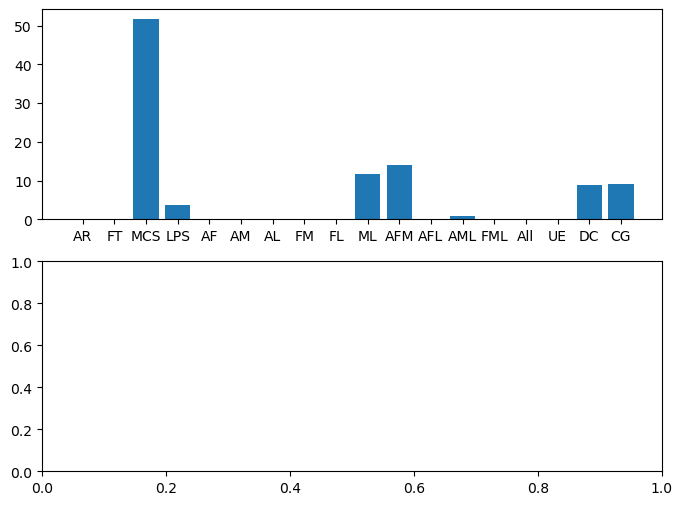

In [56]:
fig,ax = plt.subplots(2,1,figsize=(8,6))
ax[0].bar(FID_label, (Feat_ind_extreme_merged.mean(dim=['longitude','latitude','year']).FID_nth*100))
#ax[1].bar(FID_label, (Feat_ind_999th_xr.mean(dim=['longitude','latitude']).FID_p999th*100))